In [25]:
# import

import json

import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import optuna
from scipy.spatial import Delaunay
from scipy.sparse.csgraph import minimum_spanning_tree

from egraph import Graph, Coordinates, Rng, SparseSgd


In [26]:
EDGE_WEIGHT = 30
K_FROM = 1
K_TO = 20

LARGE_DATASET_NAMES = [
    '3elt.json',
    '1138_bus.json',
    'dwt_1005.json',
    'dwt_2680.json',
    'poli.json',
    'qh882.json',
    'USpowerGrid.json',
]
SMALL_DATASET_NAMES = [
    'bull.json',
    'chvatal.json',
    'cubical.json',
    'davis_southern_women.json',
    'desargues.json',
    'diamond.json',
    'dodecahedral.json',
    'florentine_families.json',
    'frucht.json',
    'heawood.json',
    'hoffman_singleton.json',
    'house_x.json',
    'house.json',
    'icosahedral.json',
    'karate_club.json',
    'krackhardt_kite.json',
    'les_miserables.json',
    'moebius_kantor.json',
    'octahedral.json',
    'pappus.json',
    'petersen.json',
    'sedgewick_maze.json',
    'tutte.json',
]

DATASET_NAMES = LARGE_DATASET_NAMES

In [27]:
# グラフの生成・読み込み

def generate_graph_from_nx_graph(nx_graph):
    graph = Graph()

    indices = {}
    for u in nx_graph.nodes:
        indices[u] = graph.add_node(u)
    for u, v in nx_graph.edges:
        graph.add_edge(indices[u], indices[v], (u, v))

    return graph, indices


def graph_preprocessing(nx_graph):
    nx_graph = nx.Graph(nx_graph)

    # グラフを無向グラフに
    nx_graph = nx_graph.to_undirected()

    # エッジのループを除去
    nx_graph.remove_edges_from(list(nx.selfloop_edges(nx_graph)))

    # 最大連結成分を用いる
    largest_cc = max(nx.connected_components(nx_graph), key=len)
    largest_cc_graph = nx_graph.subgraph(largest_cc)

    new_graph = nx.Graph()
    nodes = [str(node_id) for node_id in largest_cc_graph.nodes]
    new_graph.add_nodes_from(nodes)

    weighted_edges = []
    for edge in largest_cc_graph.edges:
        weighted_edges.append((str(edge[0]), str(edge[1]), EDGE_WEIGHT))
    new_graph.add_weighted_edges_from(weighted_edges)

    return new_graph


nx_graphs = []
dir = 'lib/egraph-rs/js/dataset/'
for filename in DATASET_NAMES:
    with open(dir + filename) as f:
        graph_data = json.load(f)

    nx_graph = nx.node_link_graph(graph_data)
    nx_processed_graph = graph_preprocessing(nx_graph)
    nx_graphs.append(nx_processed_graph)

# 追加のnx.scale_free_graph
for i in range(1, 3 + 1):
    n = i * 1000
    nx_graphs.append(graph_preprocessing(nx.scale_free_graph(n)))

    DATASET_NAMES.append(f'nx_scale_free_{n}')

graph_data = []
for nx_graph in nx_graphs:
    graph, indices = generate_graph_from_nx_graph(nx_graph)
    graph_data.append((graph, indices))


In [28]:
# shape graph生成


def generate_k_nearest_graph(pos, K, distances=None):
    k_nearest_graph = nx.Graph()

    nodes = [node_id for node_id in pos]
    k_nearest_graph.add_nodes_from(nodes)

    if distances is None:
        distances = {}
        for source in pos:
            distances[source] = []
            source_pos = np.array(pos[source])
            for target in pos:
                if target == source:
                    continue
                target_pos = np.array(pos[target])
                distance = np.linalg.norm(source_pos - target_pos)

                distances[source].append({'id': target, 'distance': distance})

        for source in pos:
            distances[source] = sorted(
                distances[source], key=lambda x: x['distance'])

    weighted_edges = []
    for source in pos:
        for distance in distances[source][:K]:
            weighted_edges.append((source, distance['id'], EDGE_WEIGHT))
    k_nearest_graph.add_weighted_edges_from(weighted_edges)

    return k_nearest_graph, distances


def generate_degree_based_k_nearest(nx_graph, pos, distances=None, degrees=None):
    k_nearest_graph = nx.Graph()

    nodes = [node_id for node_id in pos]
    k_nearest_graph.add_nodes_from(nodes)

    if distances is None:
        distances = {}
        for source in pos:
            distances[source] = []
            source_pos = np.array(pos[source])
            for target in pos:
                if target == source:
                    continue
                target_pos = np.array(pos[target])
                distance = np.linalg.norm(source_pos - target_pos)

                distances[source].append({'id': target, 'distance': distance})

        for source in pos:
            distances[source] = sorted(
                distances[source], key=lambda x: x['distance'])

    if degrees is None:
        degrees = {}
        for node_id in pos:
            degrees[node_id] = nx_graph.degree[node_id]

    weighted_edges = []
    for source in pos:
        for distance in distances[source][:degrees[node_id]]:
            weighted_edges.append((source, distance['id'], EDGE_WEIGHT))
    k_nearest_graph.add_weighted_edges_from(weighted_edges)

    return k_nearest_graph, distances, degrees


def generate_delaunay_triangulation_graph(pos):
    index_id_map = {}
    pos_array = []
    for index, node_id in enumerate(pos):
        positions = pos[node_id]
        position = [positions[0], positions[1]]
        pos_array.append(position)
        index_id_map[index] = node_id

    pos_ndarray = np.array(pos_array)
    delaunay = Delaunay(pos_ndarray)

    delaunay_triangulation_graph = nx.Graph()

    nodes = [node_id for node_id in pos]
    delaunay_triangulation_graph.add_nodes_from(nodes)

    weighted_edges = []
    for n in delaunay.simplices:
        n0 = n[0]
        n1 = n[1]
        n2 = n[2]
        weighted_edges.append(
            (index_id_map[n0], index_id_map[n1], EDGE_WEIGHT))
        weighted_edges.append(
            (index_id_map[n0], index_id_map[n2], EDGE_WEIGHT))
        weighted_edges.append(
            (index_id_map[n1], index_id_map[n2], EDGE_WEIGHT))
    delaunay_triangulation_graph.add_weighted_edges_from(weighted_edges)

    return delaunay_triangulation_graph


def generate_mst_graph(pos):
    index_id_map = {}
    pos_array = []
    for index, node_id in enumerate(pos):
        positions = pos[node_id]
        position = [positions[0], positions[1]]
        pos_array.append(position)
        index_id_map[index] = node_id

    dists = []
    for source_pos in pos_array:
        source_pos_ndarray = np.array(source_pos)
        tmp = []
        for target_pos in pos_array:
            target_pos_ndarray = np.array(target_pos)
            tmp.append(np.linalg.norm(source_pos_ndarray - target_pos_ndarray))
        dists.append(tmp)

    dists_ndarray = np.array(dists)
    mst_r = minimum_spanning_tree(dists_ndarray)

    new_nx_graph = nx.Graph()
    nodes = [node_id for node_id in pos]
    new_nx_graph.add_nodes_from(nodes)
    weighted_edges = []
    for mst_v in list(zip(*mst_r.nonzero())):
        source_id = index_id_map[mst_v[0]]
        target_id = index_id_map[mst_v[1]]
        weighted_edges.append((source_id, target_id, EDGE_WEIGHT))
    new_nx_graph.add_weighted_edges_from(weighted_edges)

    return new_nx_graph


In [29]:
# 類似度

def jaccard_similarity_sum(nx_graph, nx_shape_graph):
    j_s_sum = 0
    for node in nx_graph.nodes:
        g_n = [n for n in nx_graph.neighbors(node)]
        s_n = [n for n in nx_shape_graph.neighbors(node)]
        and_n = list(set(g_n) & set(s_n))
        or_n = list(set(g_n + s_n))

        j_s_sum += len(and_n) / len(or_n)

    return j_s_sum / len(nx_graph.nodes)


In [30]:
# グラフの描画

def draw_graph(graph, indices):
    drawing = Coordinates.initial_placement(graph)
    rng = Rng.seed_from(0)  # random seed
    sgd = SparseSgd(
        graph,
        lambda _: 30,  # edge length
        50,  # number of pivots
        rng,
    )
    scheduler = sgd.scheduler(
        100,  # number of iterations
        0.1,  # eps: eta_min = eps * min d[i, j] ^ 2
    )

    def step(eta):
        sgd.shuffle(rng)
        sgd.apply(drawing, eta)

    scheduler.run(step)

    pos = {u: (drawing.x(i), drawing.y(i)) for u, i in indices.items()}

    return pos


In [31]:
shape_based_metrics_values = {}
positions = {}

for nx_graph, data, filename in zip(nx_graphs, graph_data, DATASET_NAMES):
    graph, indices = data
    pos = draw_graph(graph, indices)

    graph_degrees = None
    distances = None

    shape_based_metrics_values[filename] = {}
    positions[filename] = pos

    # shape based metrics
    # shape graph by k-n
    for k in range(K_FROM, K_TO + 1):
        nx_shape_graph, distances = generate_k_nearest_graph(pos, k, distances)
        shape_based_metrics_values[filename][f'k={str(k).zfill(2)}-n'] = jaccard_similarity_sum(
            nx_graph, nx_shape_graph)

    # shape graph by degree based k-n
    nx_shape_graph, distances, graph_degrees = generate_degree_based_k_nearest(
        nx_graph, pos, distances, graph_degrees)
    shape_based_metrics_values[filename][f'k-n-d'] = jaccard_similarity_sum(
        nx_graph, nx_shape_graph)

    # shape graph by delaunay triangulation
    nx_shape_graph = generate_delaunay_triangulation_graph(pos)
    shape_based_metrics_values[filename][f'd-t'] = jaccard_similarity_sum(
        nx_graph, nx_shape_graph)

    # shape graph by mst
    nx_shape_graph = generate_mst_graph(pos)
    shape_based_metrics_values[filename][f'mst'] = jaccard_similarity_sum(
        nx_graph, nx_shape_graph)


In [36]:
shape_based_metrics_values

{'3elt.json': {'k=01-n': 0.14319234261501154,
  'k=02-n': 0.24131305488296903,
  'k=03-n': 0.3282065227616015,
  'k=04-n': 0.3933000891528339,
  'k=05-n': 0.4351054177696052,
  'k=06-n': 0.4548888623147118,
  'k=07-n': 0.4464208540919142,
  'k=08-n': 0.4278184580450553,
  'k=09-n': 0.40531511082536753,
  'k=10-n': 0.3828716233657184,
  'k=11-n': 0.3630184758250797,
  'k=12-n': 0.34471869408619077,
  'k=13-n': 0.3268934609321326,
  'k=14-n': 0.31027287759574357,
  'k=15-n': 0.2952376011409524,
  'k=16-n': 0.28207994328973035,
  'k=17-n': 0.26993663016967223,
  'k=18-n': 0.2586358069193075,
  'k=19-n': 0.24834224579140876,
  'k=20-n': 0.2384676798050143,
  'k-n-d': 0.3933000891528339,
  'd-t': 0.48338981757413313,
  'mst': 0.20647666128598466},
 '1138_bus.json': {'k=01-n': 0.0353605923465326,
  'k=02-n': 0.05224775301780208,
  'k=03-n': 0.06792073459588036,
  'k=04-n': 0.08126797443812546,
  'k=05-n': 0.09216312149088975,
  'k=06-n': 0.09791468575131886,
  'k=07-n': 0.10400947809326819,


In [33]:
positions

{'3elt.json': {'2': (-540.3941040039062, -244.6082763671875),
  '1': (-546.00634765625, -283.5707092285156),
  '4': (-530.718994140625, -277.30694580078125),
  '5': (-530.3917846679688, -249.77952575683594),
  '3': (-527.072265625, -197.7272186279297),
  '7': (-526.0557861328125, -209.17835998535156),
  '6': (-506.71392822265625, -163.9854278564453),
  '9': (-515.5413208007812, -147.94580078125),
  '8': (-541.708251953125, -303.068359375),
  '10': (-521.6934204101562, -235.5879364013672),
  '15': (-516.3944091796875, -267.97723388671875),
  '11': (-517.4814453125, -199.29039001464844),
  '12': (-500.8681640625, -126.74617004394531),
  '14': (-494.54119873046875, -99.06707000732422),
  '13': (-505.4921569824219, -142.22006225585938),
  '18': (-531.4935913085938, -320.8880310058594),
  '23': (-532.779541015625, -291.5096740722656),
  '16': (-492.0673828125, -69.25914764404297),
  '17': (-505.8611755371094, -206.309814453125),
  '26': (-507.2799072265625, -236.05517578125),
  '19': (-503.

In [34]:
shape_based_metrics_values_by_graph_type = {}
for filename, values in shape_based_metrics_values.items():
    for graph_type in values:
        if graph_type not in shape_based_metrics_values_by_graph_type:
            shape_based_metrics_values_by_graph_type[graph_type] = []
        shape_based_metrics_values_by_graph_type[graph_type].append(values[graph_type])


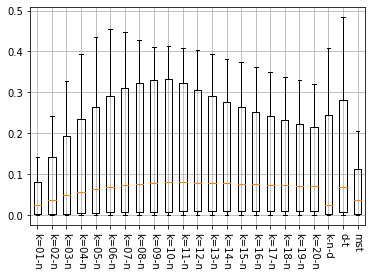

In [37]:
# 箱髭図

fig, ax = plt.subplots()

bp = ax.boxplot([v for v in shape_based_metrics_values_by_graph_type.values()])

ax.set_xticklabels(
    [graph_type for graph_type in shape_based_metrics_values_by_graph_type.keys()])
plt.xticks(rotation=-90)
plt.grid()

plt.show()


/var/folders/23/db_nbhl55hvds1mt0zx_p14h0000gn/T/ipykernel_72331/79509821.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


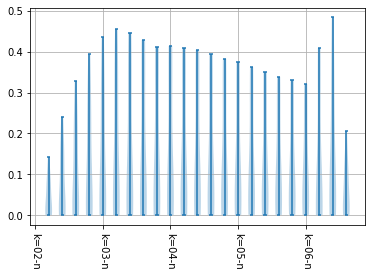

In [38]:
# ヴァイオリンプロット

fig, ax = plt.subplots()

bp = ax.violinplot([v for v in shape_based_metrics_values_by_graph_type.values()])

ax.set_xticklabels(
    [graph_type for graph_type in shape_based_metrics_values_by_graph_type.keys()])
plt.xticks(rotation=-90)
plt.grid()

plt.show()